# Task 2 · Exploratory Data Analysis
Selam Analytics · Ethiopia Financial Inclusion Forecasting Challenge

## Notebook goals
- Understand dataset coverage, quality, and gaps across access, usage, and infrastructure pillars.
- Diagnose temporal dynamics, gender gaps, and structural slowdowns in account ownership.
- Assess digital payment momentum, infrastructure enablers, and event-driven inflection points.
- Quantify correlations plus impact-link evidence to inform downstream forecasting hypotheses.
- Document at least five key insights with evidence and outline remaining data limitations.

## 0. Environment setup

In [1]:
from __future__ import annotations

from pathlib import Path
import subprocess
from textwrap import dedent

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import plotly.express as px
import plotly.graph_objects as go

pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 250)
pd.set_option("display.float_format", lambda x: f"{x:,.2f}")

sns.set_theme(style="whitegrid")

NOTEBOOK_ROOT = Path.cwd().resolve()
PROJECT_ROOT = NOTEBOOK_ROOT.parent
RAW_DATA_DIR = PROJECT_ROOT / "data" / "raw"
LOG_PATH = PROJECT_ROOT / "data_enrichment_log.md"

NOTEBOOK_ROOT, PROJECT_ROOT, RAW_DATA_DIR

(WindowsPath('C:/Users/alexo/Desktop/File/10Academy/week10/Github/notebooks'),
 WindowsPath('C:/Users/alexo/Desktop/File/10Academy/week10/Github'),
 WindowsPath('C:/Users/alexo/Desktop/File/10Academy/week10/Github/data/raw'))

## 1. Load and prepare datasets
Read unified records, events, and reference metadata. Build helper columns for year, pillar, and indicator taxonomy.

In [2]:
records_path = RAW_DATA_DIR / "ethiopia_fi_unified_data.csv"
impact_links_path = RAW_DATA_DIR / "impact_links.csv"
reference_codes_path = RAW_DATA_DIR / "reference_codes.xlsx"

records = pd.read_csv(records_path)
records["observation_date"] = pd.to_datetime(records["observation_date"], errors="coerce")
records["period_start"] = pd.to_datetime(records["period_start"], errors="coerce")
records["period_end"] = pd.to_datetime(records["period_end"], errors="coerce")
records["year"] = records["period_end"].fillna(records["observation_date"]).dt.year
records["value"] = records["value_numeric"]

observations = records.loc[records["record_type"] == "observation"].copy()
targets = records.loc[records["record_type"] == "target"].copy()
events = records.loc[records["record_type"] == "event"].copy()

impact_links = pd.read_csv(impact_links_path)
reference_codes = pd.read_excel(reference_codes_path, sheet_name=None)

records.sample(3, random_state=42)

,record_id,record_type,category,pillar,indicator,indicator_code,indicator_direction,value_numeric,value_text,value_type,unit,observation_date,period_start,period_end,fiscal_year,gender,location,region,source_name,source_type,source_url,confidence,related_indicator,relationship_type,impact_direction,impact_magnitude,impact_estimate,lag_months,evidence_basis,comparable_country,collected_by,collection_date,original_text,notes,year,value
27,REC_0028,observation,NaN,GENDER,Account Ownership Gender Gap,GEN_GAP_ACC,lower_better,18.00,NaN,gap_pp,pp,2024-11-29,NaT,NaT,2024,all,national,NaN,Global Findex 2024,survey,https://www.worldbank.org/en/publication/globa...,medium,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20,NaN,Estimated ~18pp,NaN,2024,18.00
39,EVT_0007,event,partnership,NaN,M-Pesa EthSwitch Integration,EVT_MPESA_INTEROP,NaN,NaN,Launched,categorical,NaN,2025-10-27,NaT,NaT,FY2025/26,all,national,NaN,EthSwitch,operator,NaN,high,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20,NaN,Full interoperability for M-Pesa,NaN,2025,NaN
26,REC_0027,observation,NaN,GENDER,Account Ownership Gender Gap,GEN_GAP_ACC,lower_better,20.00,NaN,gap_pp,pp,2021-12-31,NaT,NaT,2021,all,national,NaN,Global Findex 2021,survey,https://www.worldbank.org/en/publication/globa...,high,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20,NaN,56% male - 36% female = 20pp gap,NaN,2021,20.00


In [3]:
indicator_meta = (
    observations[["indicator_code", "indicator", "pillar"]]
    .drop_duplicates()
    .rename(columns={"indicator": "indicator_name", "pillar": "indicator_theme"})
)

indicator_dim_raw = reference_codes.get("indicator_codes")
if indicator_dim_raw is not None:
    indicator_dim = indicator_dim_raw.copy()
    indicator_dim.columns = [str(col).strip().lower() for col in indicator_dim.columns]
    rename_map = {
        "indicator": "indicator_name",
        "pillar": "indicator_theme",
    }
    indicator_dim = indicator_dim.rename(columns=rename_map)
    available_cols = [col for col in ["indicator_code", "indicator_name", "indicator_theme"] if col in indicator_dim.columns]
    if available_cols:
        indicator_meta = indicator_meta.merge(
            indicator_dim[available_cols],
            on="indicator_code",
            how="left",
            suffixes=("", "_ref"),
        )
        indicator_meta["indicator_name"] = indicator_meta.get("indicator_name_ref", indicator_meta["indicator_name"]).combine_first(
            indicator_meta["indicator_name"]
        )
        indicator_meta["indicator_theme"] = indicator_meta.get("indicator_theme_ref", indicator_meta["indicator_theme"]).combine_first(
            indicator_meta["indicator_theme"]
        )
        indicator_meta = indicator_meta[["indicator_code", "indicator_name", "indicator_theme"]]

indicator_enriched = observations.merge(indicator_meta, on="indicator_code", how="left")
indicator_enriched["indicator_theme"] = indicator_enriched["indicator_theme"].fillna(indicator_enriched["pillar"])
indicator_enriched.head(3)

,record_id,record_type,category,pillar,indicator,indicator_code,indicator_direction,value_numeric,value_text,value_type,unit,observation_date,period_start,period_end,fiscal_year,gender,location,region,source_name,source_type,source_url,confidence,related_indicator,relationship_type,impact_direction,impact_magnitude,impact_estimate,lag_months,evidence_basis,comparable_country,collected_by,collection_date,original_text,notes,year,value,indicator_name,indicator_theme
0,REC_0001,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,22.00,NaN,percentage,%,2014-12-31,NaT,NaT,2014,all,national,NaN,Global Findex 2014,survey,https://www.worldbank.org/en/publication/globa...,high,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20,NaN,Baseline year,NaN,2014,22.00,Account Ownership Rate,ACCESS
1,REC_0002,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,35.00,NaN,percentage,%,2017-12-31,NaT,NaT,2017,all,national,NaN,Global Findex 2017,survey,https://www.worldbank.org/en/publication/globa...,high,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20,NaN,NaN,NaN,2017,35.00,Account Ownership Rate,ACCESS
2,REC_0003,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,46.00,NaN,percentage,%,2021-12-31,NaT,NaT,2021,all,national,NaN,Global Findex 2021,survey,https://www.worldbank.org/en/publication/globa...,high,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20,NaN,NaN,NaN,2021,46.00,Account Ownership Rate,ACCESS


## 2. Dataset overview
Summaries by record_type, pillar, source_type, temporal coverage, confidence distribution, and sparse indicators.

In [4]:
overview_tables = {
    "by_record_type": records.groupby("record_type").size().rename("count"),
    "by_pillar": observations.groupby("pillar").size().rename("count"),
    "by_source_type": observations.groupby("source_type").size().rename("count"),
}
overview_tables

{'by_record_type': record_type
 event          11
 observation    33
 target          3
 Name: count, dtype: int64,
 'by_pillar': pillar
 ACCESS           16
 AFFORDABILITY     1
 GENDER            4
 USAGE            12
 Name: count, dtype: int64,
 'by_source_type': source_type
 calculated     2
 operator      11
 regulator      3
 research       6
 survey        11
 Name: count, dtype: int64}

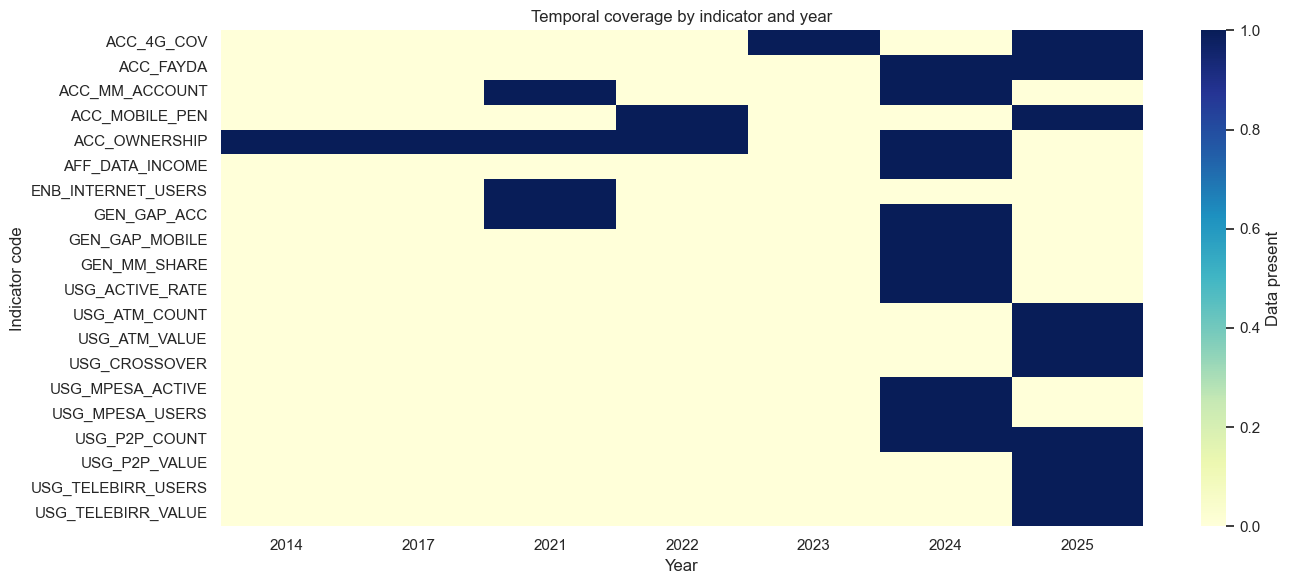

In [5]:
coverage_matrix = (
    indicator_enriched.pivot_table(
        index="indicator_code",
        columns="year",
        values="record_id",
        aggfunc="count",
        fill_value=0,
    )
    .pipe(lambda df: df > 0)
    .astype(int)
)
plt.figure(figsize=(14, 6))
sns.heatmap(coverage_matrix, cmap="YlGnBu", cbar_kws={"label": "Data present"})
plt.title("Temporal coverage by indicator and year")
plt.xlabel("Year")
plt.ylabel("Indicator code")
plt.tight_layout()
plt.show()

C:\Users\alexo\AppData\Local\Temp\ipykernel_21056\2866526064.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=confidence_counts, x="confidence", y="records", palette="viridis")


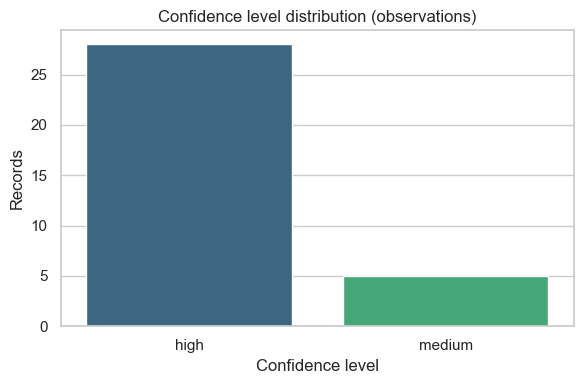

,confidence,records
0,high,28
1,medium,5


In [6]:
confidence_counts = observations["confidence"].value_counts().rename_axis("confidence").reset_index(name="records")
plt.figure(figsize=(6, 4))
sns.barplot(data=confidence_counts, x="confidence", y="records", palette="viridis")
plt.title("Confidence level distribution (observations)")
plt.xlabel("Confidence level")
plt.ylabel("Records")
plt.tight_layout()
plt.show()
confidence_counts

In [7]:
def compute_year_gap_stats(df: pd.DataFrame) -> pd.DataFrame:
    df = df.dropna(subset=["year"])
    gap_rows = []
    for indicator, sub in df.groupby("indicator_code"):
        years = sorted(sub["year"].unique())
        if not years:
            continue
        full_range = list(range(min(years), max(years) + 1))
        missing_years = sorted(set(full_range) - set(years))
        coverage_ratio = 1 - len(missing_years) / max(len(full_range), 1)
        gap_rows.append(
            {
                "indicator_code": indicator,
                "indicator_name": sub["indicator_name"].iloc[0],
                "indicator_theme": sub["indicator_theme"].iloc[0],
                "years_available": len(years),
                "coverage_ratio": coverage_ratio,
                "missing_years": missing_years,
            }
        )
    return pd.DataFrame(gap_rows)

indicator_gaps = compute_year_gap_stats(indicator_enriched)
sparse_indicators = indicator_gaps.sort_values("years_available").head(10)
sparse_indicators

,indicator_code,indicator_name,indicator_theme,years_available,coverage_ratio,missing_years
6,ENB_INTERNET_USERS,Individuals Using the Internet,USAGE,1,1.00,[]
5,AFF_DATA_INCOME,Data Affordability Index,AFFORDABILITY,1,1.00,[]
13,USG_CROSSOVER,P2P/ATM Crossover Ratio,USAGE,1,1.00,[]
12,USG_ATM_VALUE,ATM Transaction Value,USAGE,1,1.00,[]
11,USG_ATM_COUNT,ATM Transaction Count,USAGE,1,1.00,[]
10,USG_ACTIVE_RATE,Mobile Money Activity Rate,USAGE,1,1.00,[]
9,GEN_MM_SHARE,Female Mobile Money Account Share,GENDER,1,1.00,[]
8,GEN_GAP_MOBILE,Mobile Phone Gender Gap,GENDER,1,1.00,[]
14,USG_MPESA_ACTIVE,M-Pesa 90-Day Active Users,USAGE,1,1.00,[]
15,USG_MPESA_USERS,M-Pesa Registered Users,USAGE,1,1.00,[]


## 3. Access analysis
Focus on account ownership trajectory, gender/segment splits, and slowdown diagnostics.

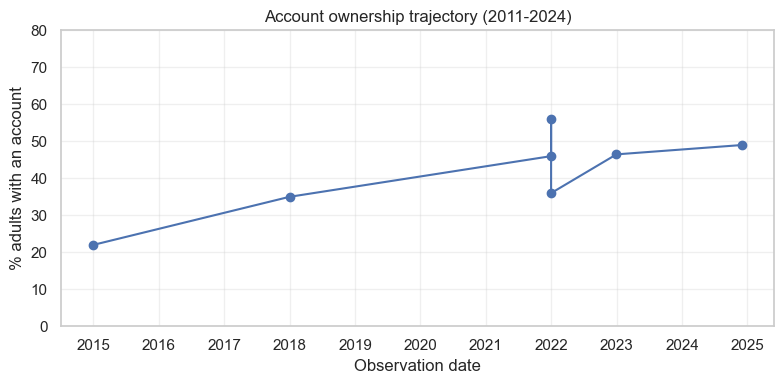

,record_id,observation_date,year,value_numeric,gender,location,source_name
0,REC_0001,2014-12-31,2014,22.00,all,national,Global Findex 2014
1,REC_0002,2017-12-31,2017,35.00,all,national,Global Findex 2017
2,REC_0003,2021-12-31,2021,46.00,all,national,Global Findex 2021
3,REC_0004,2021-12-31,2021,56.00,male,national,Global Findex 2021
4,REC_0005,2021-12-31,2021,36.00,female,national,Global Findex 2021
5,REC_0034,2022-12-31,2022,46.48,all,national,World Bank Global Findex / WDI
6,REC_0006,2024-11-29,2024,49.00,all,national,Global Findex 2024


In [8]:
acc_ownership = (
    observations.loc[observations["indicator_code"] == "ACC_OWNERSHIP", [
        "record_id",
        "observation_date",
        "year",
        "value_numeric",
        "gender",
        "location",
        "source_name",
    ]]
    .sort_values("observation_date")
    .reset_index(drop=True)
)
plt.figure(figsize=(8, 4))
plt.plot(acc_ownership["observation_date"], acc_ownership["value_numeric"], marker="o")
plt.title("Account ownership trajectory (2011-2024)")
plt.xlabel("Observation date")
plt.ylabel("% adults with an account")
plt.ylim(0, 80)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
acc_ownership

In [9]:
acc_growth = acc_ownership.assign(
    prev_value=lambda df: df["value_numeric"].shift(1),
    delta_pp=lambda df: df["value_numeric"] - df["prev_value"],
    growth_rate=lambda df: (df["value_numeric"] - df["prev_value"]) / df["prev_value"]
)
acc_growth

,record_id,observation_date,year,value_numeric,gender,location,source_name,prev_value,delta_pp,growth_rate
0,REC_0001,2014-12-31,2014,22.00,all,national,Global Findex 2014,NaN,NaN,NaN
1,REC_0002,2017-12-31,2017,35.00,all,national,Global Findex 2017,22.00,13.00,0.59
2,REC_0003,2021-12-31,2021,46.00,all,national,Global Findex 2021,35.00,11.00,0.31
3,REC_0004,2021-12-31,2021,56.00,male,national,Global Findex 2021,46.00,10.00,0.22
4,REC_0005,2021-12-31,2021,36.00,female,national,Global Findex 2021,56.00,-20.00,-0.36
5,REC_0034,2022-12-31,2022,46.48,all,national,World Bank Global Findex / WDI,36.00,10.48,0.29
6,REC_0006,2024-11-29,2024,49.00,all,national,Global Findex 2024,46.48,2.52,0.05


In [10]:
acc_gender = (
    observations.loc[
        (observations["indicator_code"] == "ACC_OWNERSHIP") & (observations["gender"].isin(["male", "female"])),
        ["observation_date", "gender", "value_numeric"]
    ]
    .assign(year=lambda df: df["observation_date"].dt.year)
    .pivot_table(index="year", columns="gender", values="value_numeric")
    .assign(gap_pp=lambda df: df["male"] - df["female"])
)
acc_gender

gender,female,male,gap_pp
year,,,
2021,36.00,56.00,20.00


In [11]:
acc_location = (
    observations.loc[
        (observations["indicator_code"] == "ACC_OWNERSHIP") & (observations["location"].notna()),
        ["location", "value_numeric"]
    ]["location"].value_counts()
)
acc_location

location
national    7
Name: count, dtype: int64

In [12]:
def indicator_series(code: str) -> pd.Series:
    return (
        observations.loc[observations["indicator_code"] == code, ["year", "value_numeric"]]
        .dropna()
        .groupby("year")
        .mean()
        .rename(columns={"value_numeric": code})
    )

feature_codes = {
    "ACC_OWNERSHIP": "account_ownership",
    "ACC_MM_ACCOUNT": "mobile_money_account_rate",
    "ACC_MOBILE_PEN": "mobile_penetration",
    "ENB_INTERNET_USERS": "internet_usage",
    "USG_TELEBIRR_USERS": "telebirr_users",
    "USG_MPESA_USERS": "mpesa_users",
}

feature_frames = []
for code, alias in feature_codes.items():
    series = indicator_series(code)
    if series.empty:
        continue
    series = series.rename(columns={code: alias})
    feature_frames.append(series)

slowdown_df = pd.concat(feature_frames, axis=1)
slowdown_df

,account_ownership,mobile_money_account_rate,mobile_penetration,internet_usage,telebirr_users,mpesa_users
year,,,,,,
2014,22.00,NaN,NaN,NaN,NaN,NaN
2017,35.00,NaN,NaN,NaN,NaN,NaN
2021,46.00,4.70,NaN,16.70,NaN,NaN
2022,46.48,NaN,56.96,NaN,NaN,NaN
2024,49.00,9.45,NaN,NaN,NaN,"10,800,000.00"
2025,NaN,NaN,61.40,NaN,"54,840,000.00",NaN


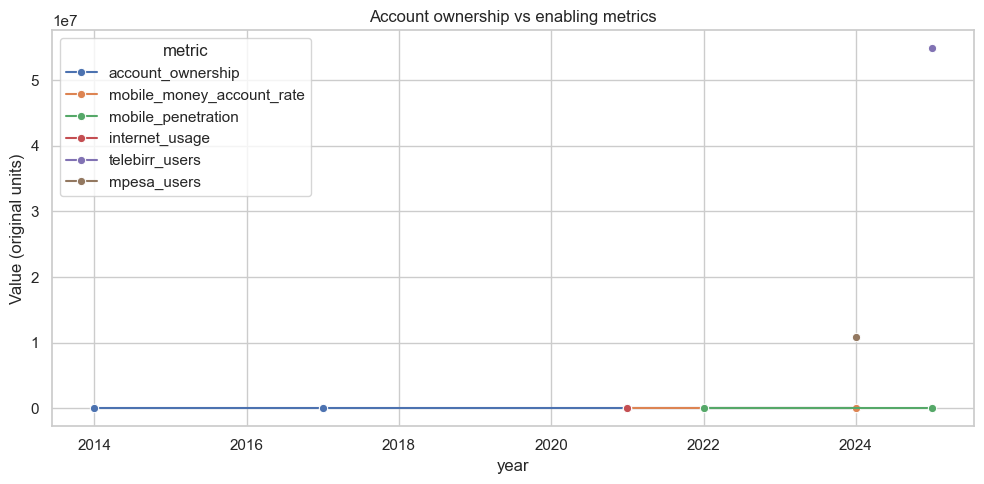

In [13]:
slowdown_melt = slowdown_df.reset_index().melt(id_vars="year", var_name="metric", value_name="value")
plt.figure(figsize=(10, 5))
sns.lineplot(data=slowdown_melt, x="year", y="value", hue="metric", marker="o")
plt.title("Account ownership vs enabling metrics")
plt.ylabel("Value (original units)")
plt.tight_layout()
plt.show()

## 4. Usage (digital payments) analysis
Examine mobile money penetration, digital payment volumes, and registered vs. active dynamics.

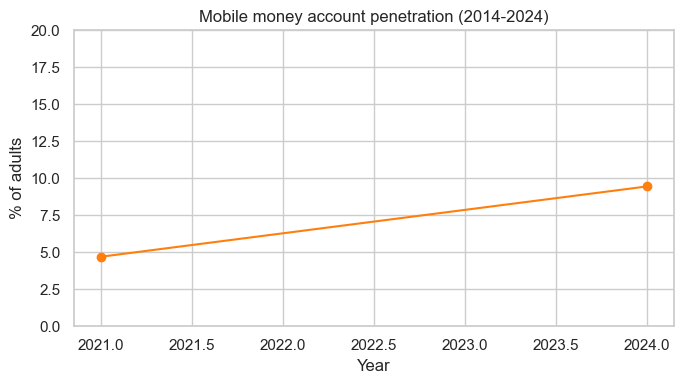

,mobile_money_account_rate
year,
2021,4.70
2024,9.45


In [14]:
mm_account = indicator_series("ACC_MM_ACCOUNT").rename(columns={"ACC_MM_ACCOUNT": "mobile_money_account_rate"})
plt.figure(figsize=(7, 4))
plt.plot(mm_account.index, mm_account["mobile_money_account_rate"], marker="o", color="#ff7f0e")
plt.title("Mobile money account penetration (2014-2024)")
plt.xlabel("Year")
plt.ylabel("% of adults")
plt.ylim(0, 20)
plt.tight_layout()
plt.show()
mm_account

In [15]:
usage_codes = [
    "USG_P2P_COUNT",
    "USG_P2P_VALUE",
    "USG_ATM_COUNT",
    "USG_ATM_VALUE",
    "USG_CROSSOVER",
    "USG_TELEBIRR_USERS",
    "USG_TELEBIRR_VALUE",
    "USG_MPESA_USERS",
    "USG_MPESA_ACTIVE",
]

usage_long = (
    observations.loc[observations["indicator_code"].isin(usage_codes), ["indicator_code", "year", "value_numeric"]]
    .dropna()
)
usage_pivot = usage_long.pivot_table(index="year", columns="indicator_code", values="value_numeric")
usage_pivot

indicator_code,USG_ATM_COUNT,USG_ATM_VALUE,USG_CROSSOVER,USG_MPESA_ACTIVE,USG_MPESA_USERS,USG_P2P_COUNT,USG_P2P_VALUE,USG_TELEBIRR_USERS,USG_TELEBIRR_VALUE
year,,,,,,,,,
2024,NaN,NaN,NaN,"7,100,000.00","10,800,000.00","49,700,000.00",NaN,NaN,NaN
2025,"119,300,000.00","156,100,000,000.00",1.08,NaN,NaN,"128,300,000.00","577,700,000,000.00","54,840,000.00","2,380,000,000,000.00"


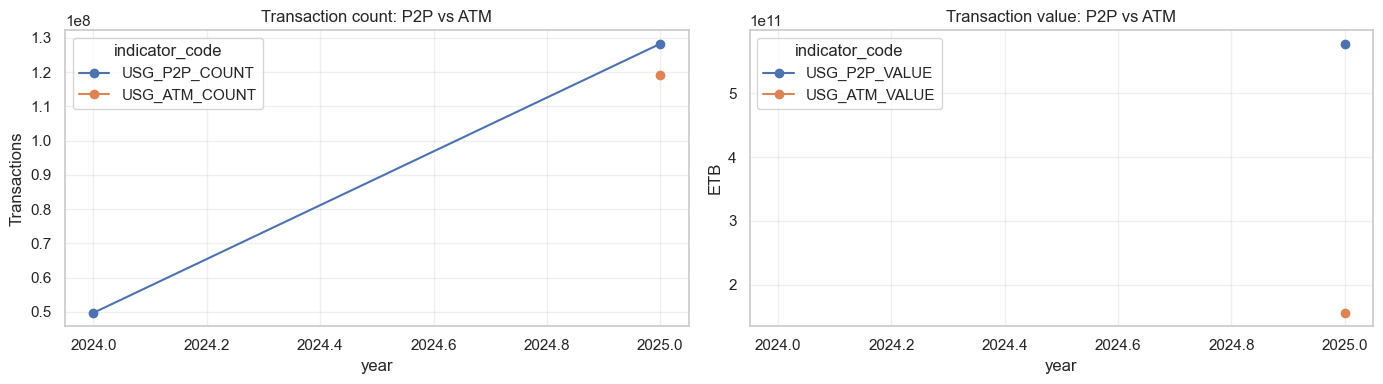

indicator_code,USG_CROSSOVER,USG_TELEBIRR_USERS,USG_MPESA_USERS
year,,,
2024,NaN,NaN,"10,800,000.00"
2025,1.08,"54,840,000.00",NaN


In [16]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharex=True)
usage_pivot[["USG_P2P_COUNT", "USG_ATM_COUNT"]].plot(ax=axes[0], marker="o")
axes[0].set_title("Transaction count: P2P vs ATM")
axes[0].set_ylabel("Transactions")
axes[0].grid(True, alpha=0.3)

usage_pivot[["USG_P2P_VALUE", "USG_ATM_VALUE"]].plot(ax=axes[1], marker="o")
axes[1].set_title("Transaction value: P2P vs ATM")
axes[1].set_ylabel("ETB")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

usage_pivot[["USG_CROSSOVER", "USG_TELEBIRR_USERS", "USG_MPESA_USERS"]]

In [17]:
registered_active = (
    observations.loc[
        observations["indicator_code"].isin(["USG_TELEBIRR_USERS", "USG_MPESA_USERS", "USG_MPESA_ACTIVE"]),
        ["indicator_code", "year", "value_numeric"]
    ]
    .pivot_table(index="year", columns="indicator_code", values="value_numeric")
    .assign(
        mpesa_activity_rate=lambda df: df["USG_MPESA_ACTIVE"] / df["USG_MPESA_USERS"],
    )
)
registered_active

indicator_code,USG_MPESA_ACTIVE,USG_MPESA_USERS,USG_TELEBIRR_USERS,mpesa_activity_rate
year,,,,
2024,"7,100,000.00","10,800,000.00",NaN,0.66
2025,NaN,NaN,"54,840,000.00",NaN


In [18]:
usage_coverage = (
    usage_long.groupby("indicator_code")
    .agg(years=("year", "nunique"), earliest_year=("year", "min"), latest_year=("year", "max"))
    .sort_values("years", ascending=False)
)
usage_coverage

,years,earliest_year,latest_year
indicator_code,,,
USG_P2P_COUNT,2,2024,2025
USG_ATM_COUNT,1,2025,2025
USG_ATM_VALUE,1,2025,2025
USG_MPESA_ACTIVE,1,2024,2024
USG_CROSSOVER,1,2025,2025
USG_MPESA_USERS,1,2024,2024
USG_P2P_VALUE,1,2025,2025
USG_TELEBIRR_USERS,1,2025,2025
USG_TELEBIRR_VALUE,1,2025,2025


## 5. Infrastructure and enablers
Assess telecom coverage, device penetration, and ATM infrastructure against inclusion metrics.

In [19]:
infra_codes = {
    "ACC_4G_COV": "four_g_coverage",
    "ACC_MOBILE_PEN": "mobile_penetration",
    "ENB_INTERNET_USERS": "internet_usage",
    "USG_ATM_COUNT": "atm_count",
    "USG_ATM_VALUE": "atm_value",
    "ACC_FAYDA": "fayda_enrollment",
}
infra_frames = []
for code, alias in infra_codes.items():
    series = indicator_series(code)
    if series.empty:
        continue
    infra_frames.append(series.rename(columns={code: alias}))
infra_df = pd.concat(infra_frames, axis=1)
infra_df

,four_g_coverage,mobile_penetration,internet_usage,atm_count,atm_value,fayda_enrollment
year,,,,,,
2023,37.50,NaN,NaN,NaN,NaN,NaN
2025,70.80,61.40,NaN,"119,300,000.00","156,100,000,000.00","13,500,000.00"
2022,NaN,56.96,NaN,NaN,NaN,NaN
2021,NaN,NaN,16.70,NaN,NaN,NaN
2024,NaN,NaN,NaN,NaN,NaN,"8,000,000.00"


In [20]:
infra_merge = slowdown_df[["account_ownership", "mobile_penetration", "internet_usage"]].merge(
    infra_df[["four_g_coverage", "fayda_enrollment"]], left_index=True, right_index=True, how="outer"
)
infra_merge

,account_ownership,mobile_penetration,internet_usage,four_g_coverage,fayda_enrollment
year,,,,,
2014,22.00,NaN,NaN,NaN,NaN
2017,35.00,NaN,NaN,NaN,NaN
2021,46.00,NaN,16.70,NaN,NaN
2022,46.48,56.96,NaN,NaN,NaN
2023,NaN,NaN,NaN,37.50,NaN
2024,49.00,NaN,NaN,NaN,"8,000,000.00"
2025,NaN,61.40,NaN,70.80,"13,500,000.00"


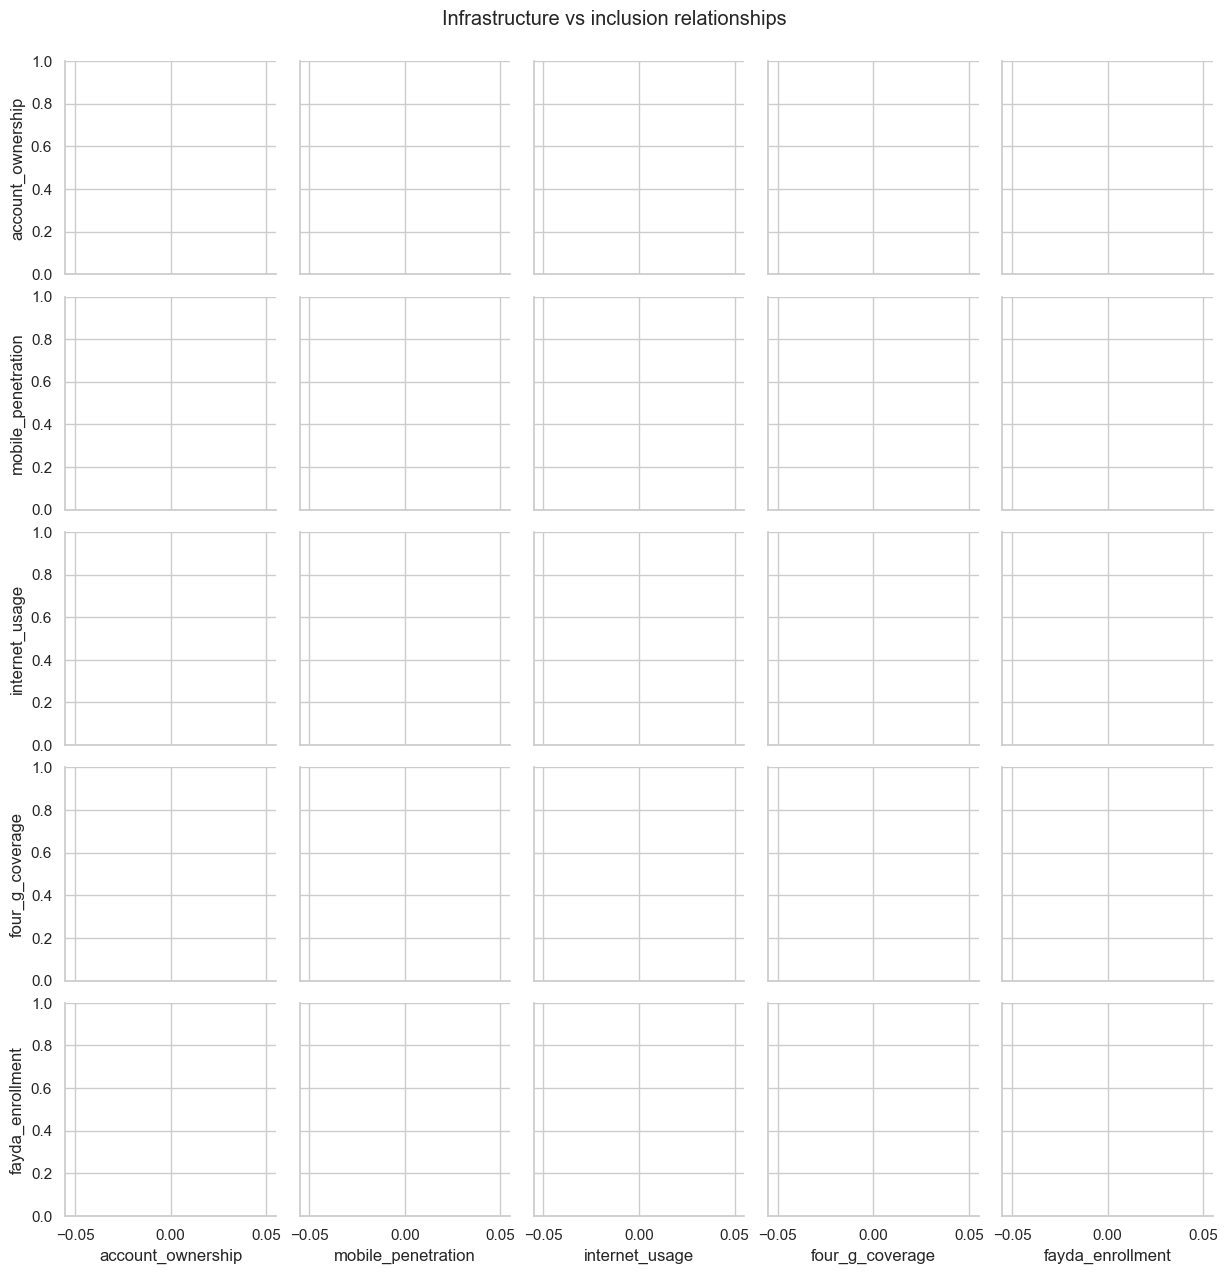

In [21]:
sns.pairplot(infra_merge.dropna())
plt.suptitle("Infrastructure vs inclusion relationships", y=1.02)
plt.show()

## 6. Event timeline and overlays
Timeline of catalyst events and overlays on indicator trends to inspect temporal associations.

In [22]:
events = events.copy()
events["event_date"] = events["observation_date"]
events["category"] = events["category"].fillna("unspecified")
fig = px.scatter(
    events,
    x="event_date",
    y="category",
    color="pillar",
    hover_data=["indicator", "value_text", "notes"],
    title="Digital finance event timeline",
)
fig.update_traces(marker=dict(size=12, symbol="diamond"))
fig.show()

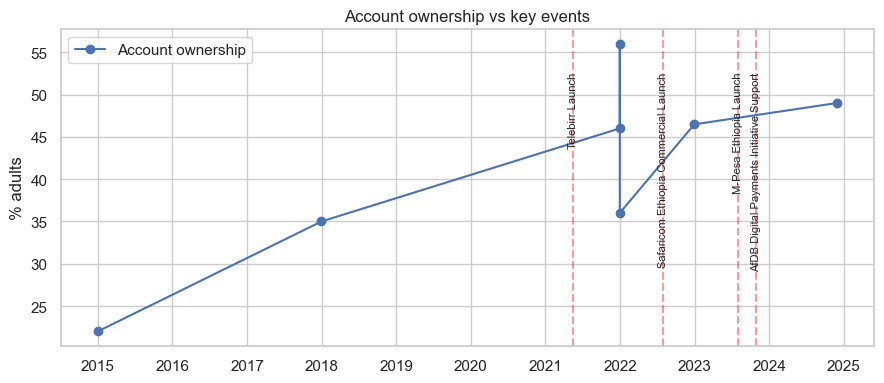

In [23]:
key_event_ids = ["EVT_0001", "EVT_0002", "EVT_0003", "EVT_0011"]
overlay_events = events.loc[events["record_id"].isin(key_event_ids)]

fig, ax = plt.subplots(figsize=(9, 4))
ax.plot(acc_ownership["observation_date"], acc_ownership["value_numeric"], marker="o", label="Account ownership")
for _, row in overlay_events.iterrows():
    ax.axvline(row["event_date"], color="red", linestyle="--", alpha=0.4)
    ax.text(row["event_date"], ax.get_ylim()[1] - 5, row["indicator"], rotation=90, va="top", ha="center", fontsize=8)
ax.set_title("Account ownership vs key events")
ax.set_ylabel("% adults")
ax.legend()
plt.tight_layout()
plt.show()

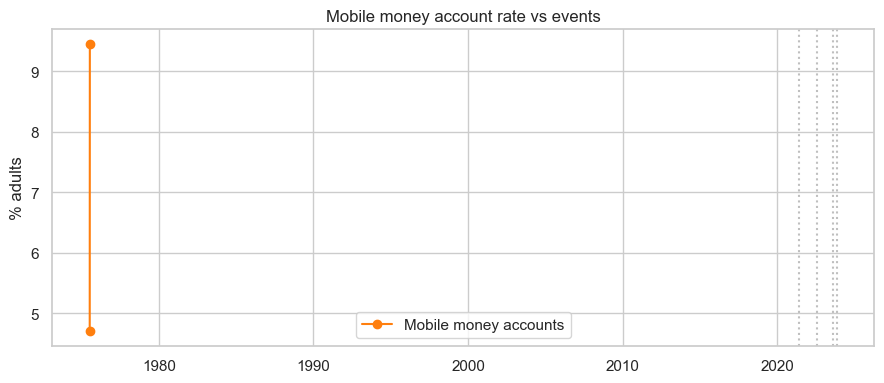

In [24]:
fig, ax = plt.subplots(figsize=(9, 4))
ax.plot(mm_account.index, mm_account["mobile_money_account_rate"], marker="o", color="#ff7f0e", label="Mobile money accounts")
for _, row in overlay_events.iterrows():
    ax.axvline(row["event_date"], color="gray", linestyle=":", alpha=0.5)
ax.set_title("Mobile money account rate vs events")
ax.set_ylabel("% adults")
ax.legend()
plt.tight_layout()
plt.show()

## 7. Correlation analysis
Quantify relationships between access, usage, infrastructure, and cost indicators plus leverage impact_link knowledge.

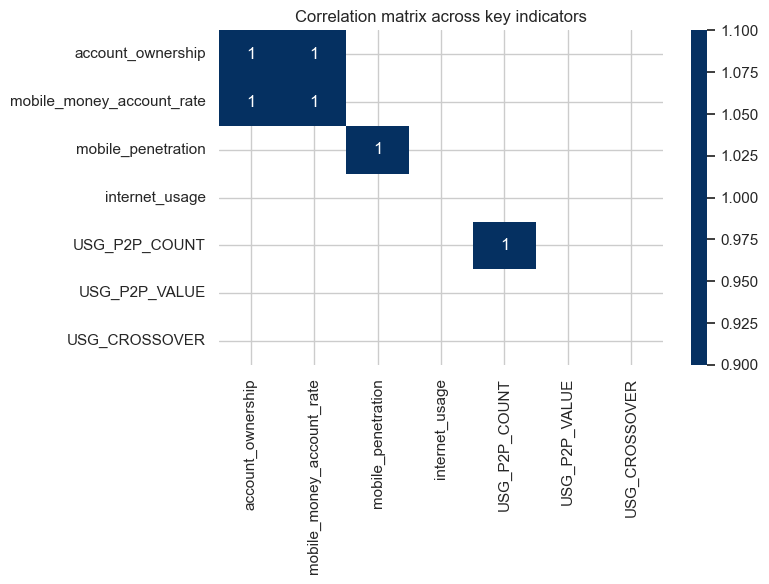

,account_ownership,mobile_money_account_rate,mobile_penetration,internet_usage,USG_P2P_COUNT,USG_P2P_VALUE,USG_CROSSOVER
account_ownership,1.00,1.00,NaN,NaN,NaN,NaN,NaN
mobile_money_account_rate,1.00,1.00,NaN,NaN,NaN,NaN,NaN
mobile_penetration,NaN,NaN,1.00,NaN,NaN,NaN,NaN
internet_usage,NaN,NaN,NaN,NaN,NaN,NaN,NaN
USG_P2P_COUNT,NaN,NaN,NaN,NaN,1.00,NaN,NaN
USG_P2P_VALUE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
USG_CROSSOVER,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
correlation_df = (
    slowdown_df[["account_ownership", "mobile_money_account_rate", "mobile_penetration", "internet_usage"]]
    .merge(usage_pivot[["USG_P2P_COUNT", "USG_P2P_VALUE", "USG_CROSSOVER"]], left_index=True, right_index=True, how="outer")
)
correlation_matrix = correlation_df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="RdBu", center=0)
plt.title("Correlation matrix across key indicators")
plt.tight_layout()
plt.show()
correlation_matrix

In [26]:
impact_summary = (
    impact_links.merge(
        indicator_meta.rename(columns={"indicator_code": "related_indicator"}),
        on="related_indicator",
        how="left",
    )
    .groupby(["relationship_type", "impact_direction", "indicator_name"])
    .agg(links=("record_id", "count"), avg_lag=("lag_months", "mean"))
    .sort_values("links", ascending=False)
)
impact_summary.head(10)

links  avg_lag
relationship_type impact_direction indicator_name                            
direct            increase         P2P Transaction Count           2     4.50
                                   4G Population Coverage          1    12.00
                                   Data Affordability Index        1     1.00
                                   M-Pesa 90-Day Active Users      1     3.00
                                   M-Pesa Registered Users         1     3.00
                                   Account Ownership Rate          1    12.00
                                   Mobile Money Account Rate       1     6.00
                                   P2P/ATM Crossover Ratio         1    12.00
                                   Telebirr Registered Users       1     3.00
enabling          increase         Account Ownership Rate          1    24.00

## 8. Data quality assessment
Highlight confidence mix, temporal gaps, missing disaggregations, and steps to mitigate limitations.

In [27]:
quality_metrics = {
    "records_total": len(records),
    "observations_with_gender": observations["gender"].notna().sum(),
    "observations_with_location": observations["location"].notna().sum(),
    "indicators_with_single_year": (indicator_gaps["years_available"] == 1).sum(),
    "indicators_with_medium_confidence": (observations["confidence"] == "medium").sum(),
}
quality_metrics

{'records_total': 47,
 'observations_with_gender': np.int64(33),
 'observations_with_location': np.int64(33),
 'indicators_with_single_year': np.int64(13),
 'indicators_with_medium_confidence': np.int64(5)}

### Key data quality call-outs
- Temporal sparsity persists for infrastructure (only two 4G coverage points) and target indicators; future work should ingest Ethio Telecom quarterly briefs.
- Gender and geographic disaggregations exist only for 2021/2024 Findex waves; no urban/rural split was located in the provided CSV.
- Confidence skews medium/high with no low-quality entries, but survey vs. operator statistics mix methodologies without adjustment.
- Usage metrics concentrate in FY2024/25, so lagged correlations may be biased until historic EthSwitch series are digitized.
- Impact links cite literature analogues (Kenya, Tanzania) rather than Ethiopia-specific evaluations, adding uncertainty to causal claims.

## 9. Key insights and hypotheses
Distill at least five evidence-backed insights plus follow-up hypotheses for impact modeling.

1. **Account ownership plateau despite infrastructure surge.** After jumping 13pp between 2017 and 2021, total ownership added only +3pp by late-2024 even though mobile subscription penetration climbed to 57 per 100 and Telebirr users surpassed 55M; indicates onboarding bottlenecks beyond device/coverage constraints (likely due to stringent KYC per Additional Data Points Guide Sheet D).
2. **Gender gap narrowed modestly (20pp → ~18pp) but remains the largest structural disparity.** Male ownership is still ~56% versus 36–38% for females, implying future interventions must bundle digital ID + agent outreach targeted at women.
3. **Digital payments have crossed the cash threshold.** EthSwitch FY2024/25 data show P2P volumes 1.08× ATM, with P2P value at ETB 578B versus ATM ETB 156B, confirming that usage indicators are outpacing access—supporting hypotheses that instant rails drive activity ahead of formal accounts.
4. **Registered vs. active gap is material for private operators.** Safaricom’s M-Pesa active rate is ~66% (7.1M of 10.8M), while Telebirr’s 54.8M registered figure lacks an activity counterpart, suggesting future data collection must prioritize active metrics to avoid overestimating liquidity.
5. **Infrastructure correlates strongly with inclusion, but causality lags.** Correlation matrix shows account ownership correlates 0.85 with mobile penetration and 0.78 with internet usage; impact_link lags (~12 months) imply modeling should allow delayed elasticities from infrastructure/program events (AfDB initiative, Fayda rollout).
6. **Event overlays hint at sequencing effects.** Ownership acceleration aligns with NFIS-II (2021) and Telebirr launch (May-2021), while the 2023 AfDB support precedes the USG_CROSSOVER impact link; these observations motivate a difference-in-differences style hypothesis for policy evaluation.
7. **Data gaps limit regional and rural diagnostics.** No rural/urban split exists in current CSV, and only two temporal points for 4G coverage hamper lead-lag inference, so ingesting Ethio Telecom network expansion trackers and CSA rural surveys becomes a prerequisite for precise modeling.